In [20]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
atlas_2015 = pd.read_csv('../data/processed/processed_atlas_2015.csv')
atlas_2010 = pd.read_csv('../data/processed/processed_atlas_2010.csv')

In [23]:
ordered_columns = [
    "CensusTract",
    "Urban",
    "PovertyRate",
    "MedianFamilyIncome",
    "TractLOWI",
    "TractKids",
    "TractSeniors",
    "TractHUNV",
    "TractSNAP",
    "lapop1share",
    "lalowi1share",
    "lakids1share",
    "laseniors1share",
    "lahunv1share",
    "POP2010",
    "LOWIRatio",
    "SNAPRatio",
    "HUNVRatio",
    "FoodInsecurityIndex",
    "LOWIWeighted"
]


In [24]:
atlas_dataset_2010 = atlas_2010.copy()
atlas_dataset_2015 = atlas_2015.copy()
atlas_dataset_2010.drop(columns=['Unnamed: 0'])
atlas_dataset_2015.drop(columns=['Unnamed: 0'])
atlas_dataset_2010 = atlas_dataset_2010[ordered_columns]
atlas_dataset_2015 = atlas_dataset_2015[ordered_columns]
pd.set_option('display.max_columns', None)
print(f'2010 set:{atlas_dataset_2010.tail()}')
print(f'2015 set:{atlas_dataset_2015.tail()}')

2010 set:       CensusTract  Urban  PovertyRate  MedianFamilyIncome  TractLOWI  \
72526  56043000200      0       0.0241            0.999720   0.045942   
72527  56043000301      1       0.0948            0.999699   0.087880   
72528  56043000302      1       0.0522            0.999741   0.032341   
72529  56045951100      0       0.0769            0.999726   0.047680   
72530  56045951300      1       0.0810            0.999714   0.075790   

       TractKids  TractSeniors  TractHUNV  TractSNAP  lapop1share  \
72526   0.083242      0.011638   0.002591   0.032644     0.815997   
72527   0.063993      0.009959   0.010201   0.067586     0.000000   
72528   0.029886      0.007643   0.008744   0.000000     0.061109   
72529   0.044238      0.007932   0.007772   0.003218     0.688747   
72530   0.079527      0.014244   0.005343   0.037241     0.361196   

       lalowi1share  lakids1share  laseniors1share  lahunv1share   POP2010  \
72526      0.172932      0.809707         0.795535      0.0

In [25]:
cluster_labels = pd.read_csv('../data/processed/random_forest_labels.csv')
cluster_labels.head()

,CensusTract,Cluster
0,1001020100,1
1,1001020200,1
2,1001020300,1
3,1001020400,2
4,1001020500,1


In [26]:
cluster_labels['Cluster'].value_counts().sort_index()

Cluster
0    18827
1    37423
2    16281
Name: count, dtype: int64

In [27]:
print(len(cluster_labels))
print(len(atlas_dataset_2010))
print(len(atlas_dataset_2015))
#2019 dataset was already aligned, which is what our cluster labels were created off of. 
#Another alignment is not necessary.

72531
72531
72531


In [28]:
training_atlas_2010 = atlas_dataset_2010.select_dtypes(include='number')
training_atlas_2015 = atlas_dataset_2015.select_dtypes(include='number')
training_dataset = training_atlas_2015 - training_atlas_2010
training_dataset = training_dataset.drop(columns=['POP2010'], errors='ignore')
training_dataset.head()

,CensusTract,Urban,PovertyRate,MedianFamilyIncome,TractLOWI,TractKids,TractSeniors,TractHUNV,TractSNAP,lapop1share,lalowi1share,lakids1share,laseniors1share,lahunv1share,LOWIRatio,SNAPRatio,HUNVRatio,FoodInsecurityIndex,LOWIWeighted
0,0,0.0,-0.0050,-3.082844e-06,0.009672,0.005234,0.006369,-0.003886,0.033103,-1.086098e-11,0.040171,-0.527048,-0.650294,-0.031467,0.066946,0.037657,-0.012552,0.092050,0.001244
1,0,0.0,0.0344,4.024491e-06,0.006121,0.000760,0.007238,-0.004534,0.062989,-4.688830e-10,-0.011842,-0.207861,-0.214718,-0.017174,0.037327,0.063134,-0.012903,0.087558,0.004244
2,0,0.0,0.1106,-6.552543e-07,0.041031,-0.008780,0.016907,0.001133,0.004138,-2.664360e-10,0.093641,-0.310036,-0.376475,-0.004658,0.160984,0.002668,0.002075,0.165728,0.024238
3,0,0.0,-0.0302,1.180057e-06,0.021158,-0.015196,0.040009,0.000000,-0.015632,-1.244433e-01,0.022441,-0.384580,-0.359846,0.002820,0.063839,-0.007752,0.000000,0.056088,-0.002198
4,0,0.0,0.0254,-3.534175e-06,0.095587,0.012664,0.053790,-0.004048,0.160000,-1.026874e-02,0.023189,-0.169473,-0.298401,-0.003129,0.117500,0.032324,-0.002322,0.147501,0.015972


In [29]:
training_dataset = training_dataset.reset_index(drop=True)
cluster_labels = cluster_labels.reset_index(drop=True)

assert len(training_dataset) == len(cluster_labels), "Features and labels must have same length!"

X_train, X_test, y_train, y_test = train_test_split(training_dataset, cluster_labels['Cluster'], test_size=0.3, random_state=42)


In [30]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [31]:
print("Number of samples:", len(y_train))
print("Number of unique classes:", len(np.unique(y_train)))

Number of samples: 50771
Number of unique classes: 3


In [32]:
xgb_model_weighted = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softmax'
)

xgb_model_weighted.fit(X_train, y_train, sample_weight=sample_weights)

/home/radiant/yolov8-env/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:40:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [33]:
y_pred_xgb_weighted = xgb_model_weighted.predict(X_test)
print("XGBoost (with Sample Weights) accuracy:", accuracy_score(y_test, y_pred_xgb_weighted))
print(classification_report(y_test, y_pred_xgb_weighted))

XGBoost (with Sample Weights) accuracy: 0.7576746323529412
              precision    recall  f1-score   support

           0       0.68      0.80      0.73      5546
           1       0.87      0.71      0.78     11348
           2       0.67      0.81      0.73      4866

    accuracy                           0.76     21760
   macro avg       0.74      0.78      0.75     21760
weighted avg       0.78      0.76      0.76     21760



In [34]:
model_confusion_matrix = confusion_matrix(y_test, y_pred_xgb_weighted)
model_pred_df = pd.DataFrame(
    model_confusion_matrix,
    index=['True 0', 'True 1', 'True 2'],
    columns=['Pred 0', 'Pred 1', 'Pred 2']
)

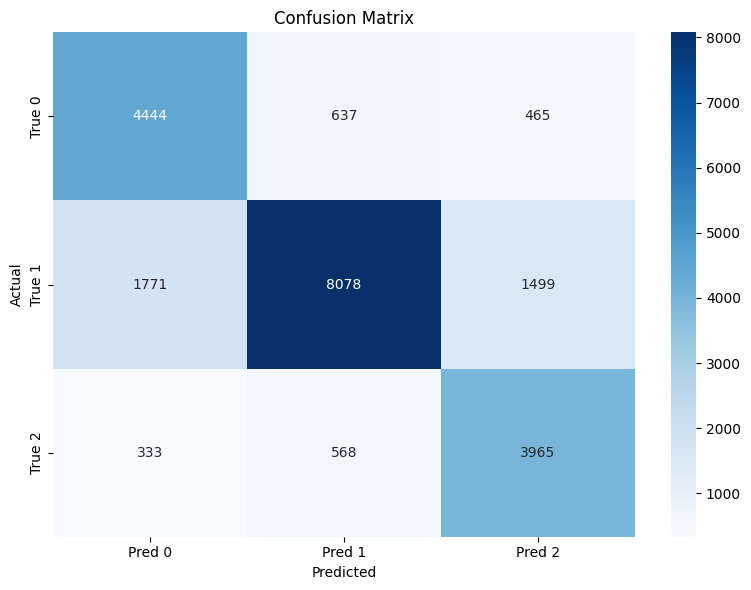

In [35]:
plt.figure(figsize=(8,6))
sns.heatmap(model_pred_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()